In [6]:
setwd('../../')
source('.Rprofile')
setwd('./benchmark/analysis')

library(ggplot2)
library(tidyverse)
library(ggpubr)
library(reshape2)
library(patchwork)

In [7]:
data <- read_csv('../results/benchmark.csv')
data$cells <- as.numeric(data$cells)
data <- data[data$global_score > 0,]
data <- data[data$cells == 0,] %>% filter(!method %in% c('SLAT', 'SLAT_harmony', 'PCA')) %>% 
        mutate(method = replace(method, method == 'SLAT_dpca', 'SLAT'))
data[nrow(data) + 1,] <- list("stereo_mouse_embryo",0,0,'PASTE',NA,NA,NA,NA,NA,NA) # PASTE can not run on Stereo-seq

data <- data %>% 
  mutate(across('dataset', str_replace, 'merfish_mouse_hypothalamic', 'MERFISH')) %>%
  mutate(across('dataset', str_replace, 'visium_human_DLPFC', 'Visium')) %>%
  mutate(across('dataset', str_replace, 'stereo_mouse_embryo', 'Stereo-seq'))
data$dataset <- factor(data$dataset, levels = c('Visium','MERFISH','Stereo-seq'))
data$method <- factor(data$method, levels = c('SLAT','PASTE','STAGATE','Harmony','Seurat'))
data %>% tail()

Rows: 1512 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): dataset, method
dbl (8): cells, seed, celltype_score, edge_score, euclidean_dis, global_scor...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


dataset,cells,seed,method,celltype_score,edge_score,euclidean_dis,global_score,region_score,run_time
<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Visium,0,7,Harmony,0.8965227,-42.64722,0.17537200,0.6132922,0.6550757,9.992527
Visium,0,7,PASTE,0.7431296,-22.83287,0.04021691,0.6404936,0.8280987,52.876152
Visium,0,7,SLAT,0.8247336,-34.17274,0.02575934,0.6968592,0.8233315,8.718221
Visium,0,7,STAGATE,0.7602356,-83.67246,0.12710486,0.5844083,0.7428491,24.356482
Visium,0,7,Seurat,0.8623107,-45.73528,0.17404606,0.6096467,0.6710600,120.943000
Stereo-seq,0,0,PASTE,NA,NA,NA,NA,NA,NA


Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


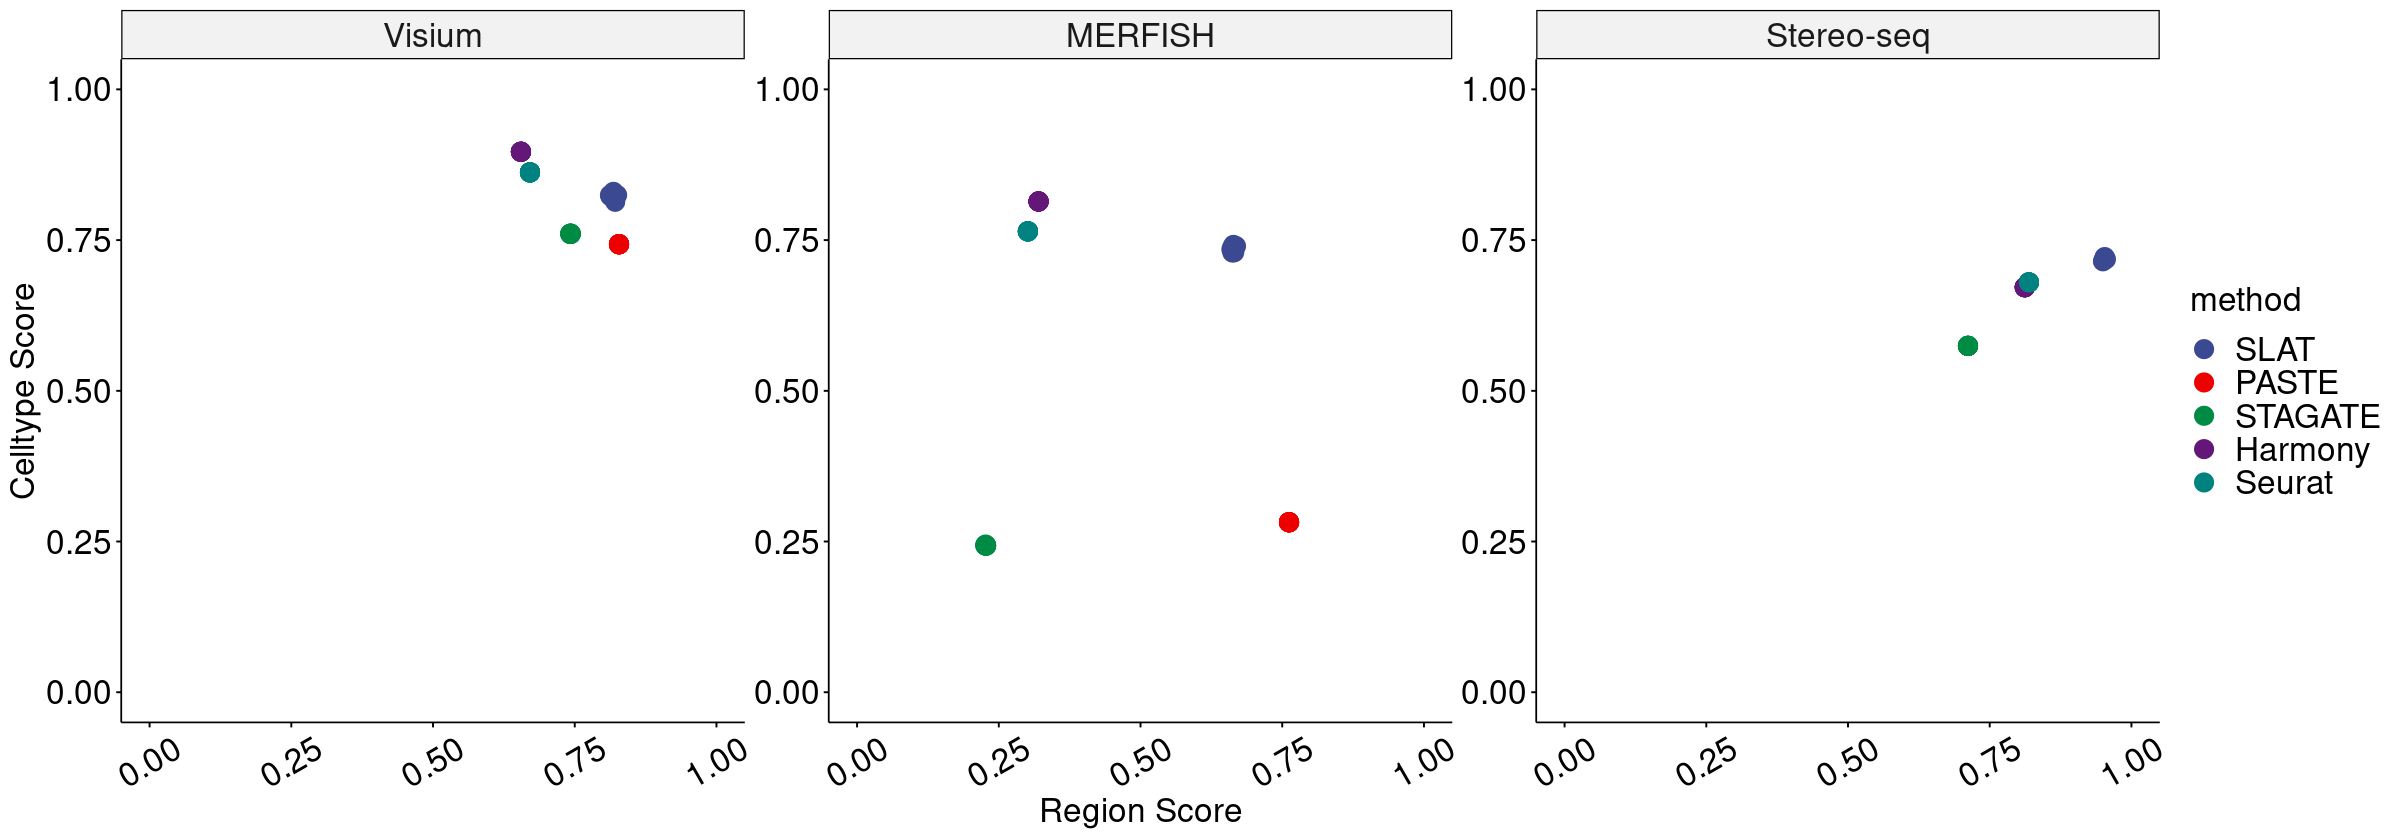

In [8]:
options(repr.plot.width=20, repr.plot.height=7)
ggscatter(data, x="region_score", y="celltype_score", color='method', size=5,
        palette='aaas', xlab='Region Score' ,ylab='Celltype Score', lab.size=30) %>% 
ggpar(xlim=c(0,1), ylim=c(0,1), legend='right', font.legend=20, font.subtitle=20, font.xtickslab=20, font.ytickslab=20, font.x=20, font.y=20) + 
facet_wrap(~dataset, scales="free") +
theme(axis.text.x=element_text(angle=30, vjust=0.5, hjust=0.5), strip.text.x=element_text(size=20))
